# **Needed Libraries**


In [1]:
# Data science 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Single cell 
import scanpy as sc
import anndata as ad
# Consider aesthetics
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['axes.axisbelow'] = True
plt.rcParams.update({'font.size': 17})
# Output control
import warnings
warnings.filterwarnings("ignore")
# Potting utils 
from utils.plotting import plot_pca

We load the file we saved from the preprocessing step:


In [2]:
adata = sc.read("processed_datasets/dataset5.h5ad")

---


# **Stage 2: Dimensionality Reduction**


In datasets with higher dimensions, there is often an increased presence of noise and redundancy. Thus when performing cell type clustering based on gene expression profiles in the next stage of the pipeline, not all genes are informative. In order to address this, we in can employ dimensionality reduction algorithms to further reduce the dimensions of single-cell RNa-seq datasets.
In our pipeline we allow the user to choose between Principal Componenent Analysis (PCA), Uniform Manifold Approximation and Projection for Dimension Reduction (UMAP) & t-distributed stochastic neighbor embedding (t-SNE).

## **PCA**

Calculates the covariance matrix of the features in the dataset and then its eigenvalues and eigenvectors. Finally it sorts them based on the value of their corresponding eigenvalue. Eigenvector / Principal componenets with larger eigenvalues carry more information about the variance present in the dataset. PCA is a linear transformation and thus can "miss" non-linear relationships between features in the dataset.


To implement the PCA transformation, we make use of the pca method in the `scnapy` preprocessing library. This method requires the adata object as input and employs the arpack solver to find the principal components, which is well-suited for sparse matrices containing numerous zero values, such as single-cell datasets. As discussed before using the identified highly variable genes is not advised, thus the parameter is set to False and all genes are considered. Finally we set the number of principal componenets to be calculated to a third of dimensions, this strikes a balance between efficiency


Upon executing the method, the adata object is enriched with additional metadata of the PCA outcome. These details can be utilized to determine the most suitable number of principal components (PCs).
Specifically:

- `adata.uns['pca']['variance']` $\rightarrow$ Is an array containing the eigenvalues of each of the PCs
- `adata.uns['pca']['variance']` $\rightarrow$ Is an array containing the cummulative variance explained from the PCs
- `adata.obsm['X_pca']` $\rightarrow$ Is a matrix containing the eigenvectors resulted from the PCA transformation


Its safe to assume the the number of principal componenets to retain will be less than half of the input dimensions for single cell data, for this reason we set the number of components of the PCA to `adata.X.shape[1]/2`


In [3]:
n_components = round(adata.X.shape[1]/2)
sc.pp.pca(adata, svd_solver='arpack',use_highly_variable=False, n_comps= n_components)
adata

AnnData object with n_obs × n_vars = 200 × 200
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

We have coded a function called `plot_pca` that utilizes `adata.obsm['X_pca']` to plot the first two PCs, labeled with their respective cummulative variance. As presented below.


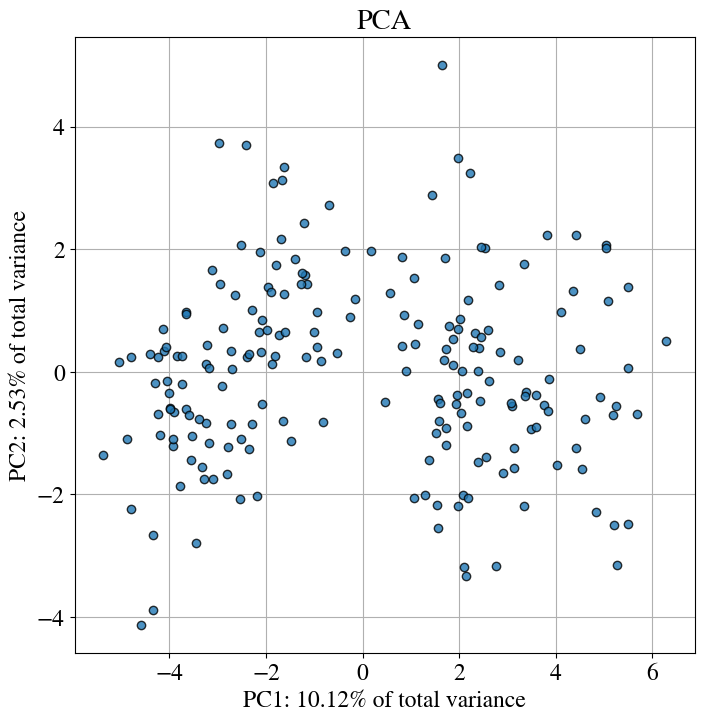

In [4]:
from utils.plotting import plot_pca
plot_pca(adata)

### _Selection the optimal number of components_

Various techniques can be employed to determine the optimal number of principal components. However, it is important to note that these methods often rely on subjective judgment.

#### 1. _Scree Plot_

One criterion involves analyzing a "Scree plot," which visually represents the number of principal components on the x-axis and their corresponding eigenvalues on the y-axis. By examining the plot, we can identify a point known as the "elbow," which indicates the principal component where the most significant change in curvature occurs. However, it is worth noting that the selection of this knee point is subjective since it relies on visual interpretation. An alternative approach is proposed in the research paper titled _"Finding a 'Kneedle' in a Haystack: Detecting Knee Points in System Behavior" by V. Satopaa, J. Albrecht, D. Irwin, and B. Raghavan (2011)_, available at [this link](https://ieeexplore.ieee.org/document/5961514). The paper presents a mathematical approach to identify knee points in an objective manner. A python implementation of the algorithm can be utilized via the `kneed` library.


Below the curve of the difference of normalized variance explained is illustrated, as you can see the knee points is the $2_{nd}$ Principal component:


Knee point is =  4


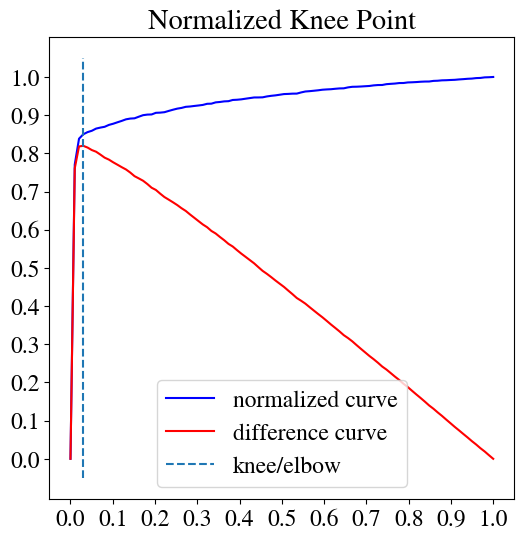

In [5]:
from kneed import KneeLocator
kneedle = KneeLocator(x =np.arange(1,adata.uns['pca']['variance'].shape[0]+1,1), y = adata.uns['pca']['variance'], S=1.0, curve="convex", direction="decreasing")
knee = round(kneedle.knee)
print("Knee point is = ", knee)
kneedle.plot_knee_normalized()

And the Scree plot representation follow below


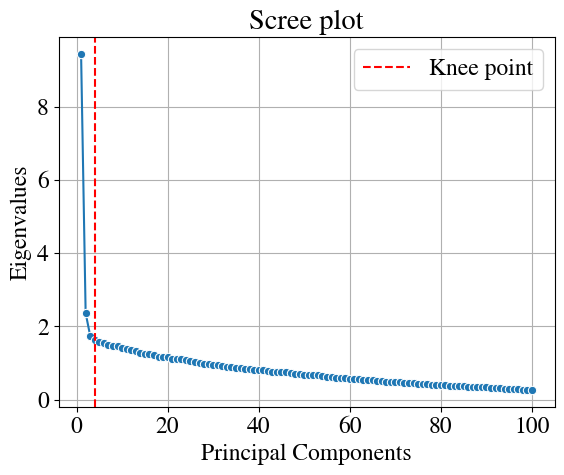

In [6]:
sns.lineplot(x = np.arange(1,adata.uns['pca']['variance'].shape[0]+1,1), y =adata.uns['pca']['variance'],marker='o')
plt.xlabel("Principal Components")
plt.axvline(x=knee, color = 'red',label = "Knee point",linestyle="dashed")
plt.ylabel("Eigenvalues")
plt.title("Scree plot")
plt.legend()
plt.grid()
plt.show()

#### 2._Variance Threshold_

Another criterion for determining the optimal number of principal components is to establish a threshold for the total variance explained by these components. Typically, this threshold falls within the range of 80% to 95%.
Below we showcase that 95 components are needed to retain $90\%$ of the variance


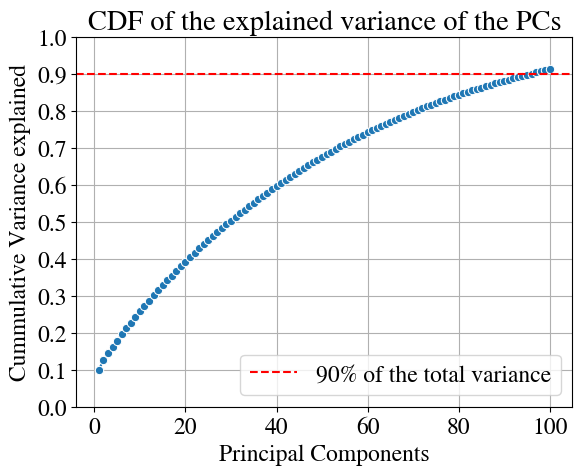

Variance Threshold of 90% keeps:  95 PCs


In [7]:
cummulative_variance = np.cumsum(adata.uns['pca']['variance_ratio'])
sns.lineplot(x = np.arange(1,adata.uns['pca']['variance'].shape[0]+1,1), y =cummulative_variance,marker='o')
plt.xlabel("Principal Components")
plt.axhline(y=0.90, color = 'red',label = "90% of the total variance",linestyle="dashed")
plt.ylabel("Cummulative Variance explained")
plt.title("CDF of the explained variance of the PCs")
plt.yticks(np.arange(0,1.1,0.1))
plt.legend()
plt.grid()
plt.show()
#Show the PCs kept with this method
print("Variance Threshold of 90% keeps: ",(cummulative_variance[cummulative_variance <= 0.90]).shape[0], "PCs")

#### 3. _Kaiser's Rule_

The Kaiser's rule, is another commonly employed technique for determining the optimal number of principal componenets to keep. The rule suggests that only principal components with variances greater than 1 should be kept. The rationale behind the Kaiser criterion is that any principal component with a variance below 1 carries less information than the original features, and therefore, it is not beneficial to retain them.


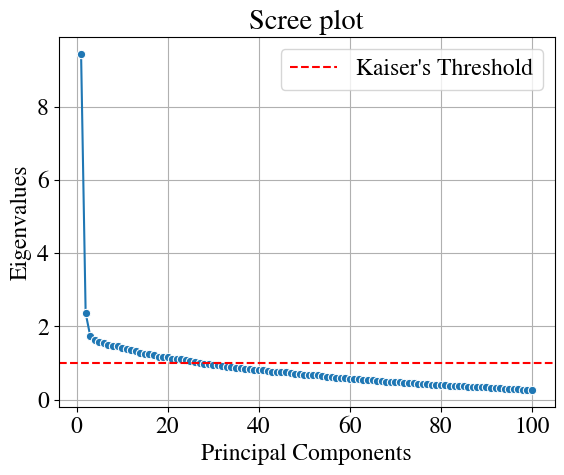

Kaiser's Threshold keeps:  26 PCs


In [8]:
sns.lineplot(x = np.arange(1,adata.uns['pca']['variance'].shape[0]+1,1), y =adata.uns['pca']['variance'],marker='o')
plt.xlabel("Principal Components")
plt.axhline(y= 1 , color = 'red',label = "Kaiser's Threshold",linestyle="dashed")
plt.ylabel("Eigenvalues")
plt.title("Scree plot")
plt.legend()
plt.grid()
plt.show()
print("Kaiser's Threshold keeps: ",(adata.uns['pca']['variance'][adata.uns['pca']['variance'] > 1]).shape[0], "PCs")

### Conclusion on the principal componenets selection method for PCA

- Variance in a dataset is relative, thus different cut-offs of total explained variance


## **T-SNE**


In [9]:
adata.obsm['X_pca']

array([[ 2.2134523 ,  3.2388465 ,  1.7251753 , ...,  0.06623375,
         0.80549157,  0.9588622 ],
       [ 1.9616657 , -0.38586172,  0.4686661 , ..., -0.05788128,
         0.45281136, -0.850765  ],
       [ 1.8791342 ,  0.11937315, -2.448195  , ...,  0.5147401 ,
        -0.6793783 , -0.4671565 ],
       ...,
       [-1.6200192 ,  3.3489203 , -2.5754795 , ..., -0.16796939,
        -0.27353564,  1.1057463 ],
       [ 1.0829095 ,  0.44972286,  4.197885  , ..., -0.17535934,
         0.1746838 ,  0.20101075],
       [ 1.7076346 ,  1.8544356 , -0.12069415, ..., -0.1020036 ,
         0.35503337,  0.7553044 ]], dtype=float32)

0.9624178409576416

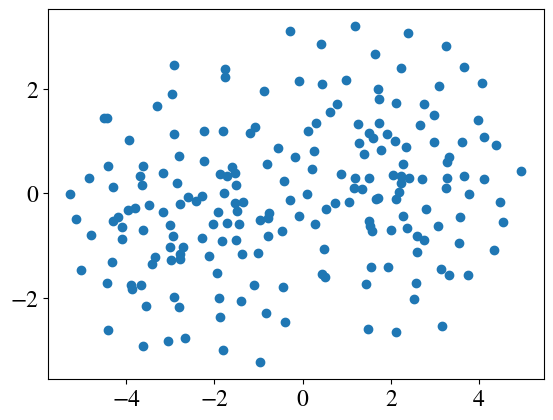

In [42]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,perplexity=perplexity, early_exaggeration=12.0, learning_rate=learning_rate, n_iter=5000, n_iter_without_progress=300, min_grad_norm=1e-07, init='pca', verbose=0, random_state=None, method='barnes_hut', angle=0.2)
X_tsne = tsne.fit_transform(adata.obsm['X_pca'][:,:95])
plt.scatter(x = X_tsne[:,0],y=X_tsne[:,1])
tsne.kl_divergence_

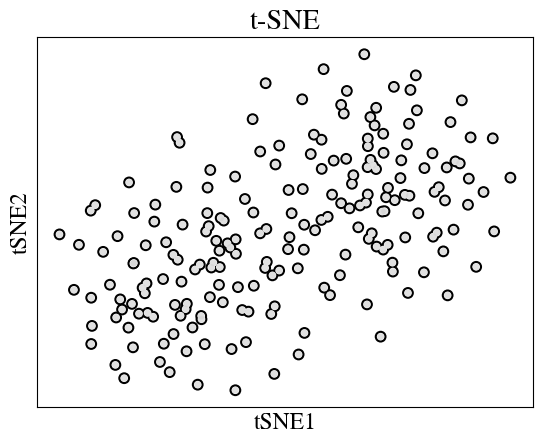

In [10]:
perplexity = 30 + adata.X.shape[0]/100
learning_rate = adata.X.shape[0]/12
n_pcs = 2

sc.tl.tsne(adata, n_pcs = 95, perplexity = perplexity, early_exaggeration=12, learning_rate = learning_rate, random_state=30, use_fast_tsne=False)
sc.pl.tsne(adata,add_outline = True, size = 100,title = "t-SNE")
plt.show()

## **UMAP**


In [12]:
# sc.tl.umap(adata, min_dist=0.5, spread=1.0, n_components=2, maxiter=None, alpha=1.0, gamma=1.0, negative_sample_rate=5, init_pos='pca', random_state=0, a=None, b=None, copy=False, method='umap', neighbors_key=None)
# sc.pl.umap(adata,add_outline = True, size = 100,show=False,title = "UMAP")

# **Stage 3: Clustering**


## Clustering the PCA dataset


In [20]:
from utils.plotting import plot_clusters
X_pca = adata.obsm['X_pca'][:,:4]

### **K-means clustering**


4


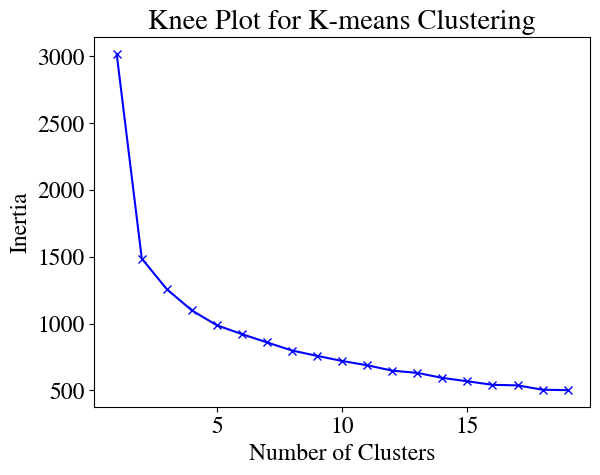

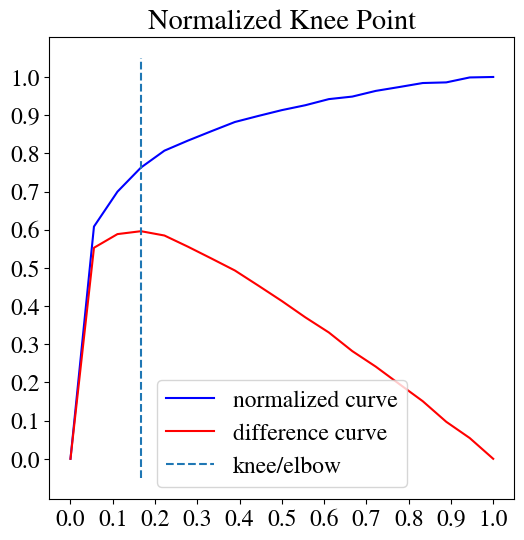

In [23]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Prepare the data (replace X with your dataset)
X = X_pca

# Determine the range of the number of clusters
clusters_range = range(1, 20)

# Perform k-means clustering for each number of clusters and calculate the inertia
inertia = []
for n_clusters in clusters_range:
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

kneedle = KneeLocator(x = np.arange(1,20,1), y = inertia, curve="convex", direction="decreasing")

# Plot the knee plot
knee = round(kneedle.knee)
print(round(knee))
plt.plot(clusters_range, inertia, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Knee Plot for K-means Clustering')
plt.show()

kneedle.plot_knee_normalized()

  0%|          | 0/50 [00:00<?, ?it/s]

The best parameters after the optimization study are: {'n_clusters': 3, 'random_state': 44}
Best average silhouette coefficient =  0.30185234546661377


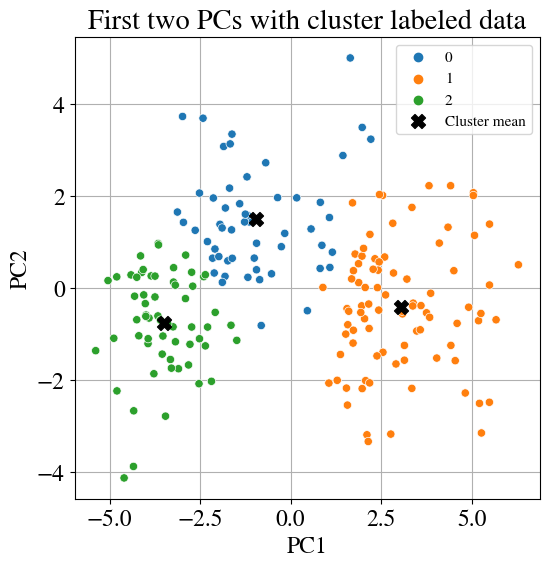

  0%|          | 0/50 [00:00<?, ?it/s]

The best parameters after the optimization study are: {'n_clusters': 3, 'random_state': 7}
Best average silhouette coefficient =  0.3834194242954254


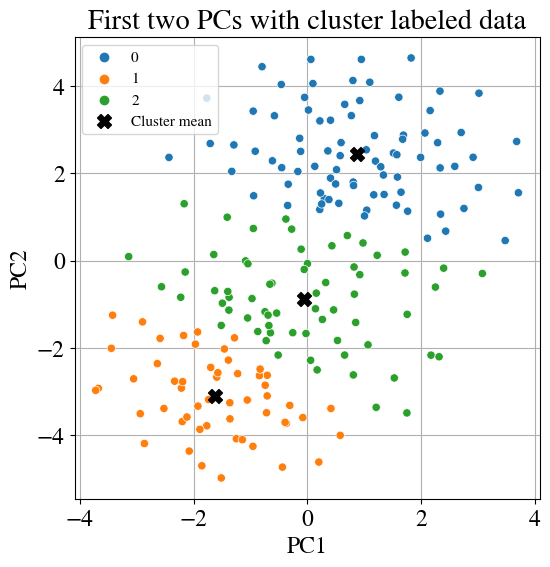

In [24]:
from utils.optimization import optimizeKmeans
from sklearn.cluster import KMeans

for X in [adata.obsm['X_pca'][:,:4],X_tsne]:
  best_params, best_value, study = optimizeKmeans(X = X, 
                                              k_range = [knee-1,knee+1],
                                              n_trials=50)

  print("The best parameters after the optimization study are:", best_params)
  print("Best average silhouette coefficient = ",best_value) 
  kmeans = KMeans(n_clusters= best_params['n_clusters'], random_state = best_params['random_state'])
  labels = kmeans.fit_predict(X)
  plot_clusters(X,labels)

In [16]:
from utils.optimization import optimizeAgglomerative
from sklearn.cluster import AgglomerativeClustering

for X in [adata.obsm['X_pca'],adata.obsm['X_tsne']]:
  best_params, best_value, study = optimizeAgglomerative(X = X, 
                                              k_range = [1,10],
                                              n_trials=100)

  print("The best parameters after the optimization study are:", best_params)
  print("Best average silhouette coefficient = ",best_value) 
  kmeans = AgglomerativeClustering(n_clusters= 4,linkage =  'ward' )
  labels = kmeans.fit_predict(X)
  plot_clusters(X,labels)

  0%|          | 0/100 [00:00<?, ?it/s]

[W 2023-05-27 00:28:14,397] Trial 0 failed with parameters: {'n_clusters': 4, 'linkage': 'ward'} because of the following error: NameError("name 'mutual_info_score' is not defined").
Traceback (most recent call last):
  File "/home/cinnabot/anaconda3/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/home/cinnabot/Desktop/Data_Science_master/semester2/ML_CB/assignment_3/utils/optimization.py", line 78, in Ward_trial
    return mutual_info_score(X, labels, )
NameError: name 'mutual_info_score' is not defined
[W 2023-05-27 00:28:14,399] Trial 0 failed with value None.


NameError: name 'mutual_info_score' is not defined